# Football Player Market Value Regression
Objective: To determine the most under and over valued players on the global football transfer market.<br> 
Dataset: Dataset of player values from Transfermarkt.com and player overall ratings from FIFA 19.<br>
Method: Using linear regression from Scikit Learn to predict player values and measure the variance.<br>
Steps: <br>
    1. Understanding the data
    2. Data Cleaning
    3. Exploratory Data Analysis and feature selection. 
    4. Train model (split dataset and train with cross validation)
    5. Regularization (Ridge, Lasso, Elastic Net)
    6. Interpret results 
    7. Data Visualizations 

### 1. Understanding the data 

In [2]:
import pandas as pd 
import numpy as np

In [11]:
#Import Data
fifa = pd.read_csv("C:\\Users\\Chung-Tseng Wang\\Desktop\\data.csv")
fifa.head()

,Unnamed: 0,ID,Name,Age,Nationality,Overall,Potential,Club,Value,Wage,Special,Preferred Foot,Work Rate,Body Type,Position,Release Clause
0,0,158023,L. Messi,31,Argentina,94,94,FC Barcelona,€110.5M,€565K,2202,Left,Medium/ Medium,Messi,RF,€226.5M
1,1,20801,Cristiano Ronaldo,33,Portugal,94,94,Juventus,€77M,€405K,2228,Right,High/ Low,C. Ronaldo,ST,€127.1M
2,2,190871,Neymar Jr,26,Brazil,92,93,Paris Saint-Germain,€118.5M,€290K,2143,Right,High/ Medium,Neymar,LW,€228.1M
3,3,193080,De Gea,27,Spain,91,93,Manchester United,€72M,€260K,1471,Right,Medium/ Medium,Lean,GK,€138.6M
4,4,192985,K. De Bruyne,27,Belgium,91,92,Manchester City,€102M,€355K,2281,Right,High/ High,Normal,RCM,€196.4M


As you can see above, the dataset provides a wide range of attributes for each player. <br>
Since we only want attributes that correlate with market value, we will go ahead and remove irrlevant attributes. <br>
Attributes to keep: <br>
Overall - Player's overall rating according to the popular football game FIFA 19. <br>
Value - The market value of the player according to transfermarkt.com<br>
Wage - Player's weekly wage according to transfermarkt.com<br>
Release Clause - A clause in a contract that imposes an obligation to another organization wishing to acquire the player.<br>
Age - Age of the player as of 2019<br>

In [12]:
fifa = fifa[['Name','Overall','Value','Wage','Release Clause','Age']]
fifa.head()

,Name,Overall,Value,Wage,Release Clause,Age
0,L. Messi,94,€110.5M,€565K,€226.5M,31
1,Cristiano Ronaldo,94,€77M,€405K,€127.1M,33
2,Neymar Jr,92,€118.5M,€290K,€228.1M,26
3,De Gea,91,€72M,€260K,€138.6M,27
4,K. De Bruyne,91,€102M,€355K,€196.4M,27


The dataset above contains only continuous player attributes that may have a correlation with market value. However, after taking a glance at the data we can see that Value, Wage, and Release Clause are all objects with currency signs and numeral abbreviations. We want to convert these objects into integers, remove currency signs and abbreviations, and remove players with missing values. 

In [5]:
fifa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18207 entries, 0 to 18206
Data columns (total 6 columns):
Name              18207 non-null object
Overall           18207 non-null int64
Value             18207 non-null object
Wage              18207 non-null object
Release Clause    16643 non-null object
Age               18207 non-null int64
dtypes: int64(2), object(4)
memory usage: 853.5+ KB


### 2. Data Cleaning

In [13]:
#Data Preparation
for c in list(['Value','Wage','Release Clause']):
    fifa[c] = fifa[c].astype(str)
    fifa[c] = fifa[c].str.replace('€','')
    for i in fifa.index:
        if '.' in fifa.loc[i,c]:
            fifa.loc[i,c] = fifa.loc[i,c].replace('M','00000')
            fifa.loc[i,c] = fifa.loc[i,c].replace('K','00')
        else:
            fifa.loc[i,c] = fifa.loc[i,c].replace('M','000000')
            fifa.loc[i,c] = fifa.loc[i,c].replace('K','000')
    fifa[c] = fifa[c].str.replace('.','')
    fifa = fifa.dropna()
    fifa[c] = fifa[c].astype(int)
fifa.head()

,Name,Overall,Value,Wage,Release Clause,Age
0,L. Messi,94,110500000,565000,226500000,31
1,Cristiano Ronaldo,94,77000000,405000,127100000,33
2,Neymar Jr,92,118500000,290000,228100000,26
3,De Gea,91,72000000,260000,138600000,27
4,K. De Bruyne,91,102000000,355000,196400000,27


In [14]:
fifa.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16643 entries, 0 to 18206
Data columns (total 6 columns):
Name              16643 non-null object
Overall           16643 non-null int64
Value             16643 non-null int32
Wage              16643 non-null int32
Release Clause    16643 non-null int32
Age               16643 non-null int64
dtypes: int32(3), int64(2), object(1)
memory usage: 715.1+ KB


As you can see we have converted each column into the integer data type (except name) and removed currency signs and abbreviations. You may also notice that there are less rows now since we removed rows with missing values in any column.

### 3. Exploratory Data Analysis

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style = 'ticks', color_codes = True)
plt.rcParams['figure.figsize'] = (20,10)
plt.style.use('ggplot')

The objective of doing exploratory data analysis is to understand the correlation between each attribute. Our goal here is to identify the best attribute(s) to predict market value. First, we will run create a pairplot using seaborn to get a general visualization of our data. Second, we will use lasso regression to help us with feature selection. 

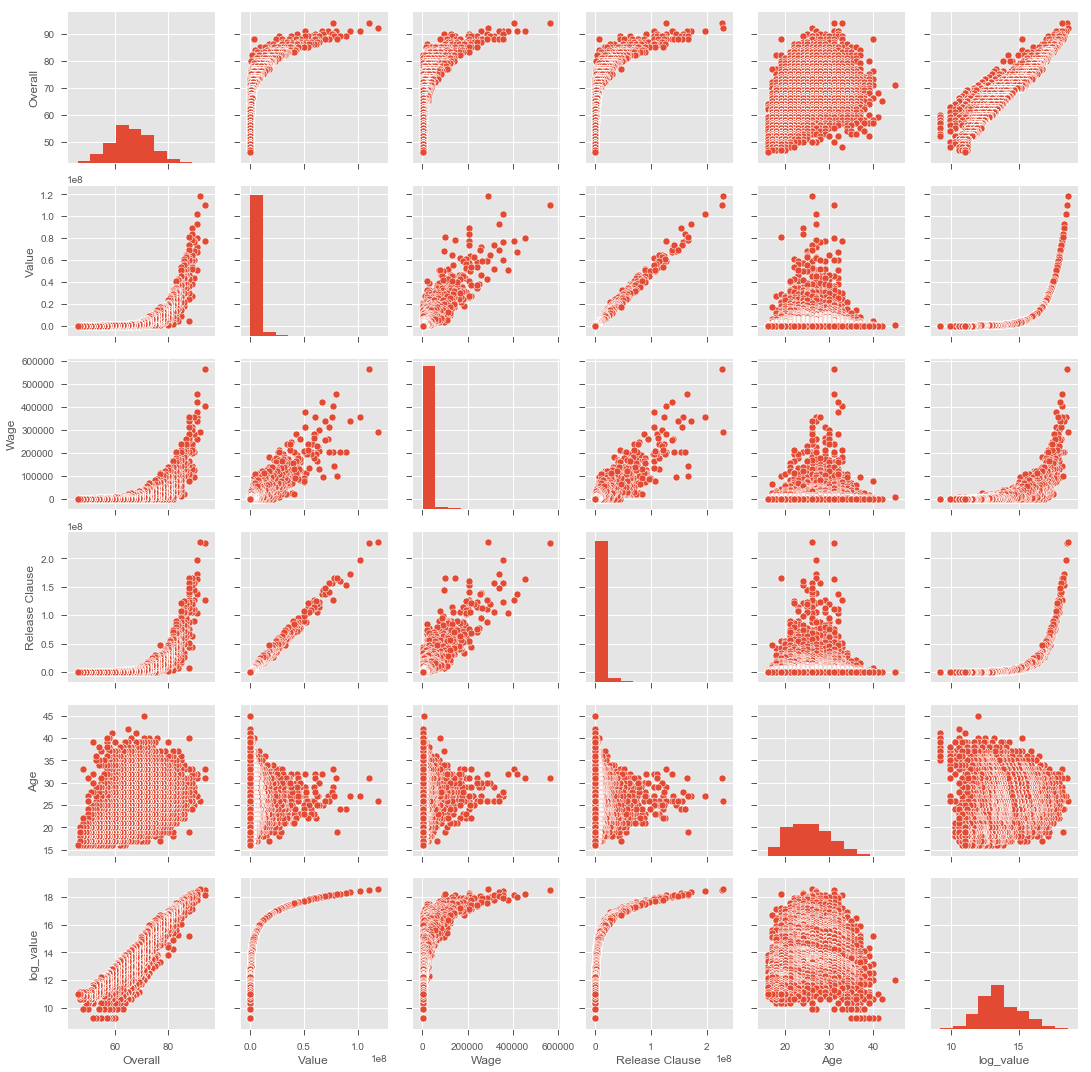

In [40]:
#Pairplot 
sns.pairplot(fifa)
plt.show()

As you can see above that from a glance, the relationship between release clause and market value is linear. However, we're also interested in the correlation between a player's overall rating and market value. The pairplot above shows an exponential relationship between a player's overall rating and market value. Thus, for us to use a linear model on an exponential relationship, we need to do a log transformation on the Overall values. 

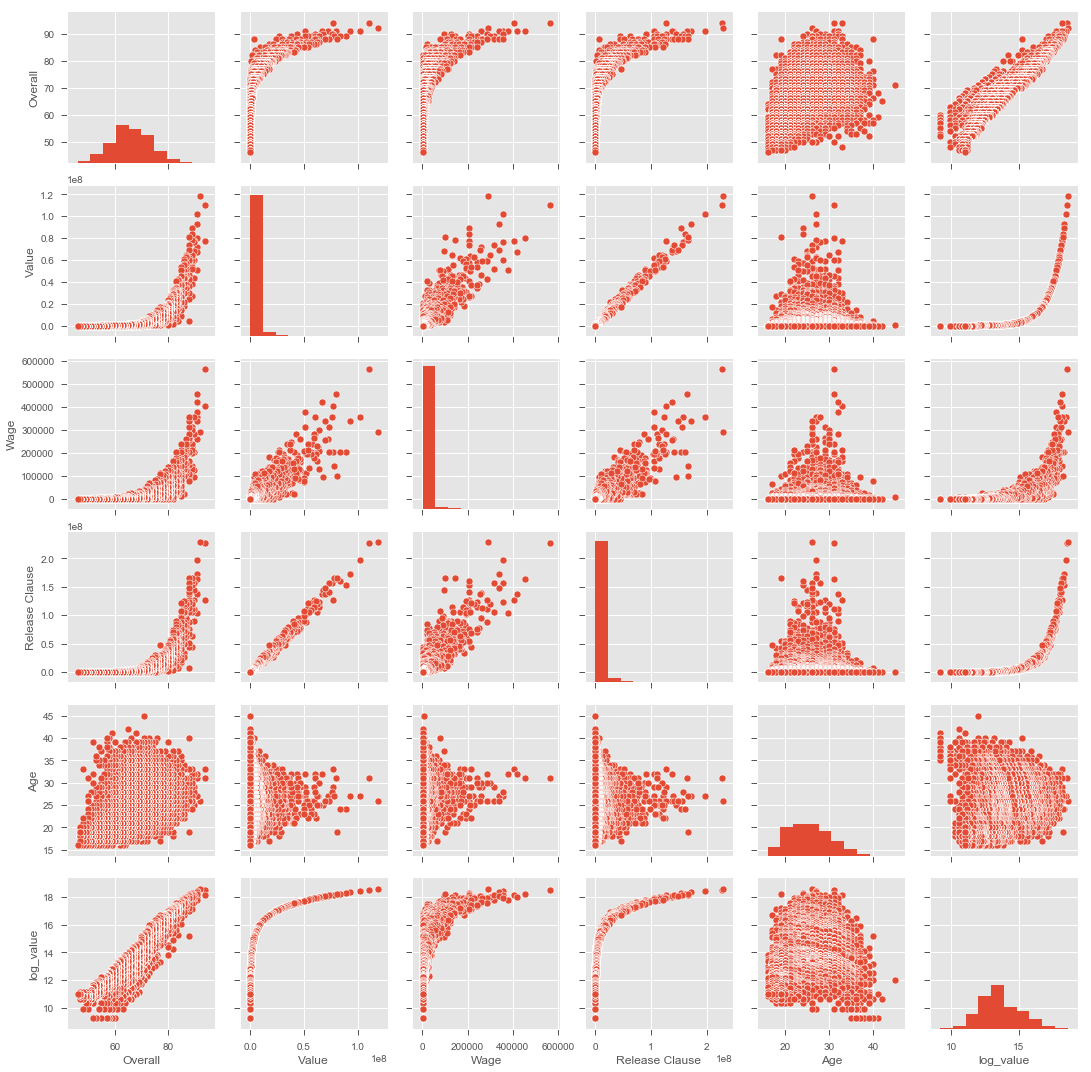

In [17]:
fifa['log_value'] = np.log(fifa['Value'])
sns.pairplot(fifa)
plt.show()

Now we can see in the upper right hand corner that the relationship between log_value and Overall is linear. Next we will use Lasso regression for feature selection. 

In [18]:
from sklearn.linear_model import Lasso

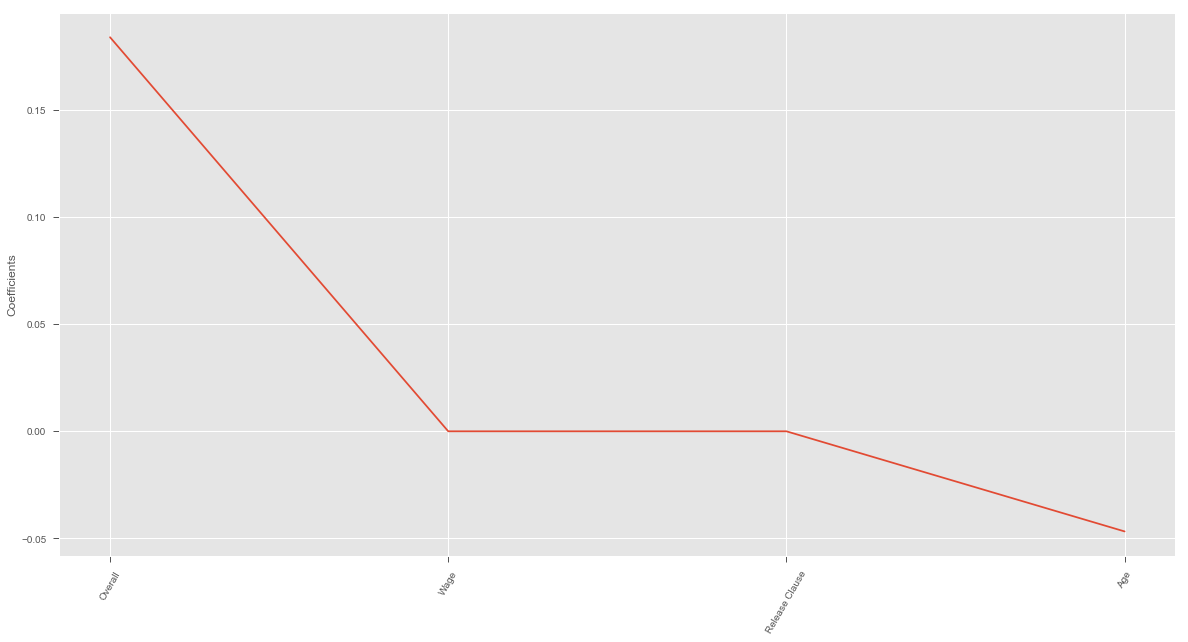

In [41]:
attributes = fifa.drop(['Value','log_value','Name'],axis = 1).columns
lasso = Lasso(alpha = 0.001, normalize = True)
X = fifa.drop(['Value','log_value','Name'],axis = 1)
y = fifa['log_value']
lasso_coef = lasso.fit(X,y).coef_
_ = plt.plot(range(len(attributes)), lasso_coef)
_ = plt.xticks(range(len(attributes)), attributes, rotation = 60)
_ = plt.ylabel('Coefficients')
plt.show()

As you can see above, the most important predictor for a player's log market value is the player's overall rating since it has the highest lasso coefficient. 

Since the relationship between player market value against wage and release clause are also linear, we will be introducing a second model with both of the features. 

### 4. Train Model - Predicting player market value from a single feature (Overall Rating)

In [20]:
from sklearn import linear_model

In [43]:
X = fifa['Overall'].reshape(-1,1)
y = fifa['log_value'].reshape(-1,1)

C:\Users\Chung-Tseng Wang\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  """Entry point for launching an IPython kernel.
C:\Users\Chung-Tseng Wang\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  


In [44]:
reg = linear_model.LinearRegression()
reg.fit(X,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

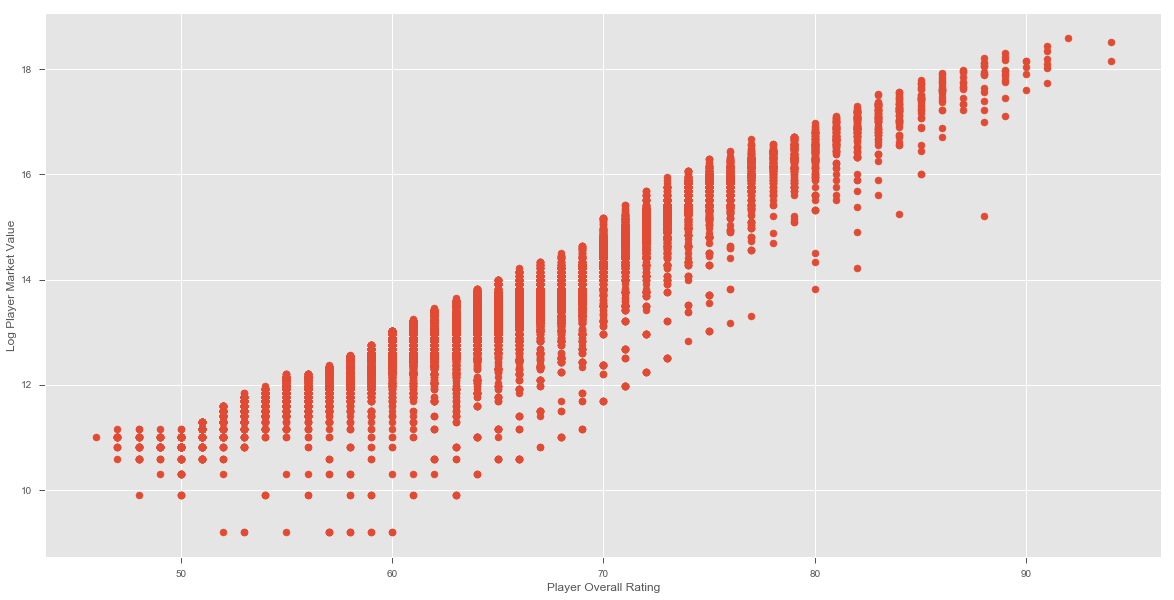

In [45]:
plt.scatter(X,y)
plt.ylabel('Log Player Market Value')
plt.xlabel('Player Overall Rating')
plt.show()

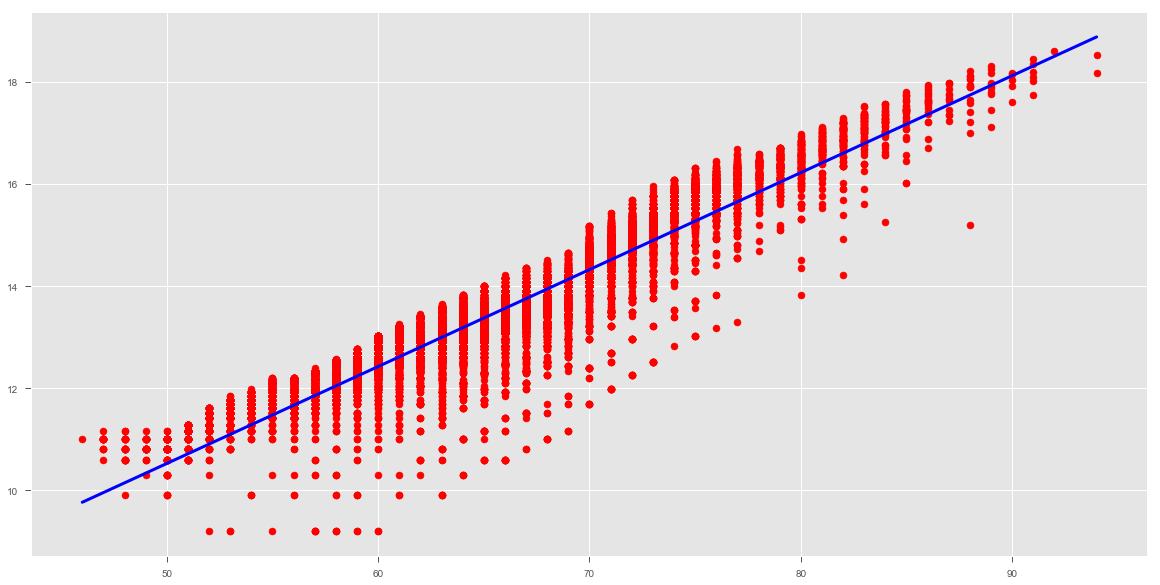

In [46]:
prediction_space = np.linspace(min(X),max(X)).reshape(-1,1)
plt.scatter(X,y,color = 'red')
plt.plot(prediction_space, reg.predict(prediction_space),color = 'blue', linewidth = 3)

As you can see above, we have our linear regression plotted over our scatter plot. 
Next, we want to put our model to the test and see how accurate it's predictions are.  
Steps:
1. Use Train-Test-Split to randomly break up our data set into a training portion and a testing portion
2. Apply our regression model 
3. Eliminate model bias using cross-validation 

In [25]:
#Train, test, split
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, random_state = 24)

In [26]:
#Fit training data into Linear Regression Model
Reg = linear_model.LinearRegression()
Reg.fit(X_train, y_train)
#Test model on test data
y_pred = Reg.predict(X_test)
Reg.score(X_test, y_test)

0.8785512892501841

In [27]:
#Cross Validation 
from sklearn.model_selection import cross_val_score
cv_results = cross_val_score(Reg,X_test,y_test,cv = 10)
cv_results

array([0.87345775, 0.86423444, 0.89943549, 0.87690728, 0.86381076,
       0.86358069, 0.88080936, 0.8928804 , 0.87001204, 0.89365645])

In [28]:
#Taking the mean of the cross validation scores 
np.mean(cv_results)

0.8778784657242715

As you can see above we applied 5 fold cross validation to our model and the mean result is around 87.787%. 

### 5. Regularization 

In this section, we will try out different methods of regularization to see if it improves our model. 

In [29]:
from sklearn.linear_model import Ridge

In [30]:
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X,y,test_size = 0.3,random_state = 42)
ridge = Ridge(alpha = 0.001, normalize = True)
ridge.fit(X_train_r, y_train_r)
ridge_pred = ridge.predict(X_test_r)
ridge.score(X_test_r,y_test_r)

0.8765147132858837

In [31]:
from sklearn.linear_model import ElasticNet

In [32]:
X_train_e, X_test_e, y_train_e, y_test_e = train_test_split(X,y,test_size = 0.3,random_state = 12)
en = ElasticNet(alpha = 0.001, normalize = True)
en.fit(X_train_e, y_train_e)
en_pred = ridge.predict(X_test_e)
en.score(X_test_e,y_test_e)

0.22926384571626723

As you can see above, neither Ridge or Elastic Net regression improves the model. 

### 6. Result Interpretation 

In [59]:
fifa.head()

,Name,Overall,Value,Wage,Release Clause,Age,log_value,predicted_log_value
0,L. Messi,94,110500000,565000,226500000,31,18.520526,18.879750
1,Cristiano Ronaldo,94,77000000,405000,127100000,33,18.159316,18.879750
2,Neymar Jr,92,118500000,290000,228100000,26,18.590424,18.499812
3,De Gea,91,72000000,260000,138600000,27,18.092177,18.309842
4,K. De Bruyne,91,102000000,355000,196400000,27,18.440483,18.309842


In [60]:
fifa['predicted_log_value'] = Reg.predict(fifa['Overall'].reshape(-1,1))
fifa.head()

C:\Users\Chung-Tseng Wang\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  """Entry point for launching an IPython kernel.


,Name,Overall,Value,Wage,Release Clause,Age,log_value,predicted_log_value
0,L. Messi,94,110500000,565000,226500000,31,18.520526,18.879750
1,Cristiano Ronaldo,94,77000000,405000,127100000,33,18.159316,18.879750
2,Neymar Jr,92,118500000,290000,228100000,26,18.590424,18.499812
3,De Gea,91,72000000,260000,138600000,27,18.092177,18.309842
4,K. De Bruyne,91,102000000,355000,196400000,27,18.440483,18.309842


In [78]:
fifa['value_difference'] = fifa['predicted_log_value'] - fifa['log_value']
fifa.head(10)

,Name,Overall,Value,Wage,Release Clause,Age,log_value,predicted_log_value,value_difference
0,L. Messi,94,110500000,565000,226500000,31,18.520526,18.879750,0.359224
1,Cristiano Ronaldo,94,77000000,405000,127100000,33,18.159316,18.879750,0.720434
2,Neymar Jr,92,118500000,290000,228100000,26,18.590424,18.499812,-0.090612
3,De Gea,91,72000000,260000,138600000,27,18.092177,18.309842,0.217666
4,K. De Bruyne,91,102000000,355000,196400000,27,18.440483,18.309842,-0.130641
5,E. Hazard,91,93000000,340000,172100000,27,18.348110,18.309842,-0.038268
6,L. Modrić,91,67000000,420000,137400000,32,18.020203,18.309842,0.289639
7,L. Suárez,91,80000000,455000,164000000,31,18.197537,18.309842,0.112305
8,Sergio Ramos,91,51000000,380000,104600000,32,17.747336,18.309842,0.562506
9,J. Oblak,90,68000000,94000,144500000,25,18.035018,18.119873,0.084855


In [73]:
top_over_valued_players = fifa.sort_values('value_difference', ascending = True)[fifa['Overall'] > 75]
top_over_valued_players.head(10)

C:\Users\Chung-Tseng Wang\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,Name,Overall,Value,Wage,Release Clause,Age,log_value,predicted_log_value,value_difference
1143,Vinícius Júnior,77,17500000,66000,46800000,17,16.677711,15.650274,-1.027437
1522,A. Ćorić,76,14000000,38000,26600000,21,16.454568,15.460305,-0.994263
1343,I. Sarr,76,13500000,22000,28400000,20,16.418200,15.460305,-0.957895
1070,P. Cutrone,77,16000000,62000,30400000,20,16.588099,15.650274,-0.937825
1172,N. Barella,77,15500000,24000,29500000,21,16.556351,15.650274,-0.906077
1149,R. Bentancur,77,15500000,62000,28700000,21,16.556351,15.650274,-0.906077
1422,B. Embolo,76,12500000,24000,23800000,21,16.341239,15.460305,-0.880934
1231,Wendel,76,12500000,10000,27500000,20,16.341239,15.460305,-0.880934
1403,M. Dembélé,76,12000000,43000,25200000,21,16.300417,15.460305,-0.840112
1327,K. Dolberg,76,12000000,15000,19200000,20,16.300417,15.460305,-0.840112


In [76]:
top_under_valued_players = fifa.sort_values('value_difference', ascending = False)[fifa['Overall'] > 80] 
top_under_valued_players.head(10)

C:\Users\Chung-Tseng Wang\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,Name,Overall,Value,Wage,Release Clause,Age,log_value,predicted_log_value,value_difference
41,G. Buffon,88,4000000,77000,7400000,40,15.201805,17.739935,2.538130
318,Casillas,82,1500000,10000,3000000,37,14.220976,16.600120,2.379144
152,A. Barzagli,84,4200000,95000,6900000,37,15.250595,16.980058,1.729463
317,P. Čech,82,3000000,60000,5700000,36,14.914123,16.600120,1.685997
314,Dani Alves,82,4800000,62000,8900000,35,15.384126,16.600120,1.215993
224,Pepe Reina,83,6000000,56000,10200000,35,15.607270,16.790089,1.182819
108,Pepe,85,9000000,57000,17100000,35,16.012735,17.170027,1.157292
102,Naldo,85,9000000,38000,15300000,35,16.012735,17.170027,1.157292
231,Juiano Mestres,82,6500000,39000,12400000,34,15.687313,16.600120,0.912807
223,D. De Rossi,83,8000000,80000,13600000,34,15.894952,16.790089,0.895137


In this section, we will take a look at our results and interpret the meaning. 
Steps:
1. Use StatsModel to view our OLS Regression Results
2. Check for regression assumptions
    Assumptions to check 
        1. Linearity 
        2. Independence
        3. Equal Variance 
        4. Normality 
3. Interpret results and answer main question

In [34]:
import statsmodels.api as sm
from statsmodels.formula.api import ols 

C:\Users\Chung-Tseng Wang\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [35]:
#Regression Summary of Regression #1
mod = ols(formula = 'y ~ X', data = fifa)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.879
Model:                            OLS   Adj. R-squared:                  0.879
Method:                 Least Squares   F-statistic:                 1.210e+05
Date:                Fri, 26 Jul 2019   Prob (F-statistic):               0.00
Time:                        16:48:34   Log-Likelihood:                -11846.
No. Observations:               16643   AIC:                         2.370e+04
Df Residuals:                   16641   BIC:                         2.371e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.0403      0.036     28.670      0.0

From the above OLS regression table we can see that the equation of our regression is: <br>
log(Player Market Value) = 0.1897(Player Overall Rating) + 1.0403 <br>
Key statistics to evaluate: 
1. R^2: At 0.879, we have a relatively high coefficient of determination. Meaning there is a high portion of the variance in the dependent variable that is predictable form the independent variable. <br>
2. P-value: With a p-value of 0, we can reject null hypothesis and conclude the results are stitstically significant. <br>
3. Coefficient Standard error: 
    Intercept: The standard error for intercept is 0.036 and it is relatively low to its coefficient of 1.0403
    X: The standard error for X is 0.001 and it is also relatively low compare to its coefficient of 0.1897. 

In [36]:
#Anova Table for 
anova_table = sm.stats.anova_lm(res,type = 2)
print(anova_table)

               df        sum_sq       mean_sq              F  PR(>F)
X             1.0  29422.799019  29422.799019  121027.116596     0.0
Residual  16641.0   4045.579307      0.243109            NaN     NaN


C:\Users\Chung-Tseng Wang\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\Chung-Tseng Wang\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\Chung-Tseng Wang\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


Checking model assumptions: 
1. Linearity: From the results of the scatter plot and the pairplot, we can safely assume that the relationship between log(Player market value) and player overall rating is linear. 
2. Statistical independence of the errors: To check for statistical independence of errors we will look at the residual vs. predicted plot. As you can see below, there doesn't seem to be a pattern in the graph so we can conclude that the errors are independent. 
3. Equal variance: From the graph below we can see that the errors aren't spread equally around 0, in fact there is actually more data points with negative residuals. This could potentially be a problem in your model. 
4. Residual Normality: To check for residual normality we will create a 

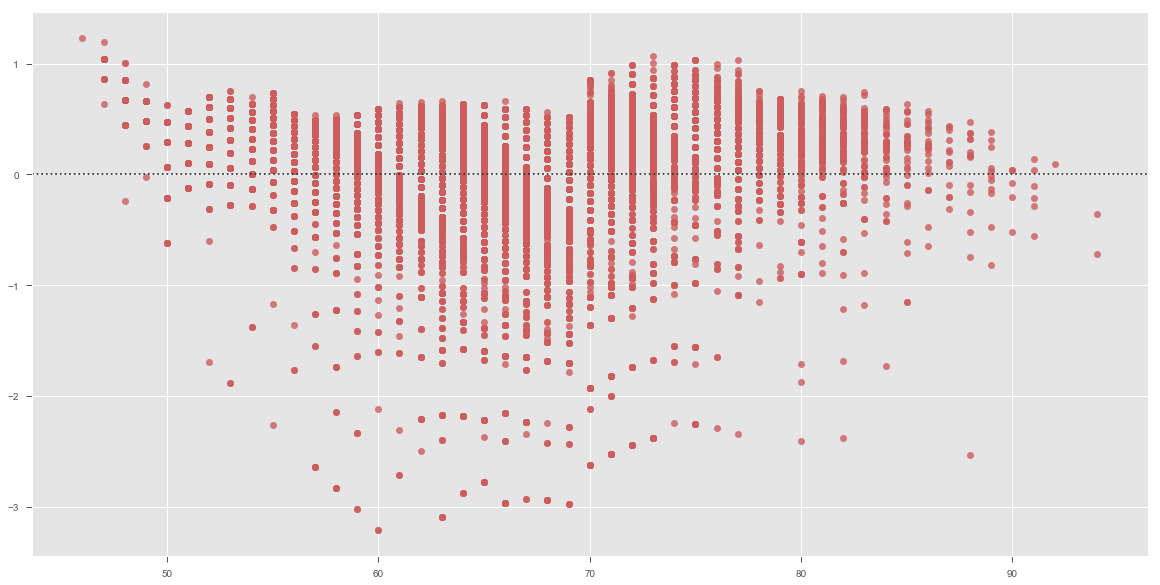

In [77]:
#Residual Plot 
sns.residplot(x = X, y = y, data = fifa, color = 'indianred')
plt.show()

In [38]:
#Quantile plot 
import scipy as sp
fig, ax = plt.subplot(figsize = (6,2.5))
plt.scatter()

AttributeError: Unknown property figsize

<Figure size 432x288 with 0 Axes>